In [2]:
from bert_embedding import BertEmbedding
  
import numpy as np 
import pandas as pd
  
from sklearn import cluster
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
CITY = 'sydney'

In [8]:
def zomatoPreprocess(city):
    #Zomato preprocessing

    zomato = pd.read_csv(city+'.csv')
    zomato = zomato[['name','cuisines']].dropna(axis=0)

    cuisines = zomato.cuisines.apply(lambda x:x.replace('[','')
                                                .replace(']','')
                                                .replace('"','')
                                                .replace(',',' ')
                                                .replace('and','') + ' food'
                                                .replace('  ',' '))

    names = zomato.name.values
    
    return cuisines, names

# BERT: Bidirectional Encoder Representations from Transformers

#### Abstract:

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT representations can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE benchmark to 80.4% (7.6% absolute improvement), MultiNLI accuracy to 86.7 (5.6% absolute improvement) and the SQuAD v1.1 question answering Test F1 to 93.2 (1.5% absolute improvement), outperforming human performance by 2.0%.

.

###### This notebook uses the bert-embeddings pypi package which builds off of gluon-nlp https://pypi.org/project/bert-embedding/

.

In [21]:
def stack(embeddings,stacked=[],n=0):

    if len(stacked)>0: x = stacked
    else: x = embeddings[0]
    
    try:stacked = np.add(np.array(x), embeddings[1])
    except:return np.array(x)
    
    n += 1
    
    return stack(embeddings[1:],stacked=stacked,n=n)



def __bagofBERTs(restaurants,berts):
    
    output = []
    
    for restaurant,(cuisines,embeddings) in zip(restaurants,berts):
        embedding = stack(embeddings)
        output += [(restaurant,cuisines,embedding)]
        
    return output



def getEmbeddings(n_restaurants=100,city=CITY):
    
    print('Cleaning Zomato data for {}.\n'.format(city))
    cuisines, names = zomatoPreprocess(CITY.lower())
    
    print('Retrieving BERT sentence representations for {} restuarants.\n'.format(n_restaurants))
    __bert_embedding = BertEmbedding(model='bert_12_768_12')
    __berts = __bert_embedding(cuisines[:n_restaurants])
    bagofembeddings = __bagofBERTs(names, __berts)
    
    print('Complete.')
    
    filtrd = [(n,c,e) for n,c,e
              in bagofembeddings 
                  if len(e.shape)>0]

    cuisines = [c for n,c,e in filtrd]
    embeds = [e for n,c,e in filtrd]
    names = [n for n,c,e in filtrd]
    
    return names,cuisines,embeds
    

In [22]:
names, cusines, embeds = getEmbeddings()

Cleaning Zomato data for sydney.

Retrieving BERT sentence representations for 100 restuarants.

Complete.


In [24]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(embeds)

pca0 = principal_components[:,0]
pca1 = principal_components[:,1]
pca2 = principal_components[:,2]

pca.explained_variance_

array([[ 1.06280013e+01,  3.13439971e+01,  2.78392505e+01,
         8.93143560e+00,  1.86219441e+01, -2.63728096e-01,
        -3.46756218e+00, -4.41859462e+00, -1.65572934e+00,
        -2.48794134e+00, -5.39408794e+00,  8.91846557e-02,
         1.73789187e+00, -2.72483155e-02, -4.67582104e+00,
        -4.48780754e+00,  2.88822442e-01,  1.19769465e-01,
         3.77726705e-01,  5.50761050e-01, -1.68091241e+00,
         7.04350919e-01, -5.36388374e-01, -4.09236293e-01,
         7.34923564e-01,  8.06846525e-01, -1.13654966e-01,
         2.97116156e-01,  6.69452633e-01, -5.62453121e-01]])

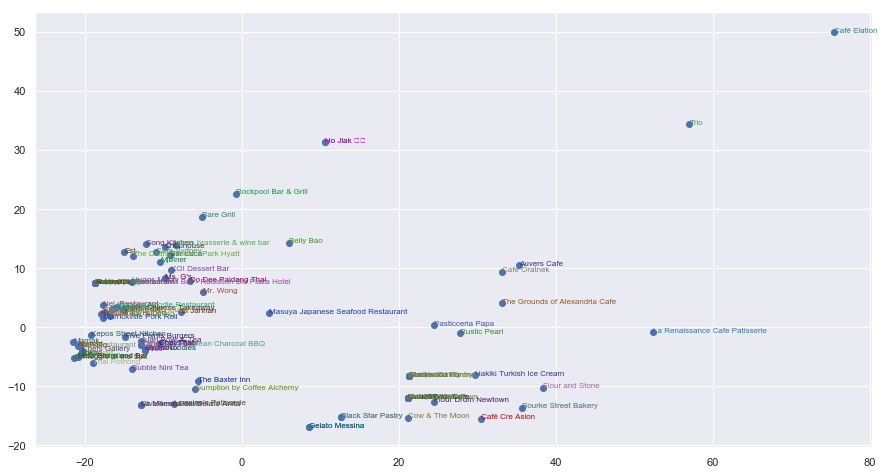

In [27]:
plt.figure(figsize=(15,8))
plt.scatter(pca0,pca1)
for i, x, y in zip(names, pca0, pca1):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.show()

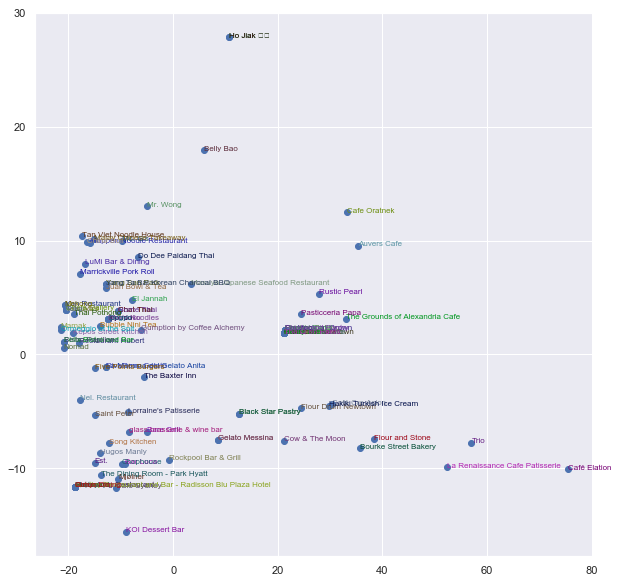

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(pca0,pca2)
for i, x, y in zip(names, pca0, pca2):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.show()

In [29]:
names, cusines, embeds = getEmbeddings(1000)

Cleaning Zomato data for sydney.

Retrieving BERT sentence representations for 1000 restuarants.

Complete.


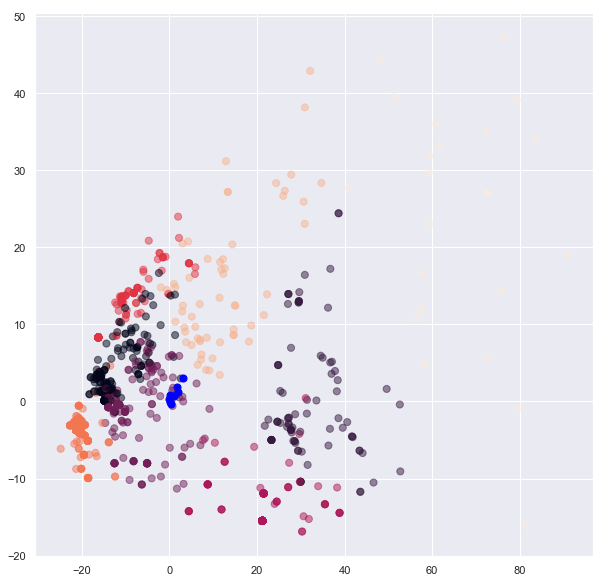

In [30]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(embeds)

pca0 = principal_components[:,0]
pca1 = principal_components[:,1]
pca2 = principal_components[:,2]

principal_components[:2]

kmeans = cluster.KMeans(n_clusters=8).fit(embeds)
centroids = kmeans.cluster_centers_


sns.set()
plt.figure(figsize=(10,10))
plt.scatter(pca0,pca1,c=kmeans.labels_.astype(float), s=50, alpha=0.5)
#for n, (i, x, y) in enumerate(zip(names, pca0, pca1)):
#    if n % 4 == 0: plt.text(x,y,i, fontsize=13)
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=50)

Text(0, 0.5, '# of member restaurants')

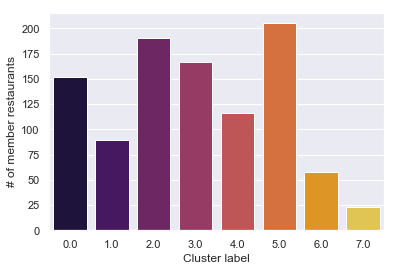

In [31]:
labels = sorted(kmeans.labels_.astype(float))
Y = [labels.count(x) for x in set(labels)]
X = list(set(labels))

sns.barplot(X,Y,palette='inferno')
plt.xlabel('Cluster label')
plt.ylabel('# of member restaurants')